In [1]:
import numpy as np
import pandas as pd
import csv
import math
from mt2 import mt2
import sys
sys.path.append("MLAnalysis")
from joblib import Parallel, delayed

import matplotlib.pyplot as plt

from MLAnalysis.Interfaces.LHCOlympics import LoadLHCOlympics
from MLAnalysis.CutAndExport.CutEvent import CutEvents
from MLAnalysis.CutAndExport.Histogram import *

from MLAnalysis.DataStructure.EventSet import *
from MLAnalysis.DataStructure.Particles import *

def mt(pt, etmiss, phi, etmiss_phi):
    # Calculate azimuthal angle difference
    delta_phi = np.abs(phi - etmiss_phi)
    if delta_phi > np.pi:
        delta_phi = 2 * np.pi - delta_phi

    # Calculate transverse mass
    mt = np.sqrt(2 * pt * etmiss * (1 - np.cos(delta_phi)))
    
    return mt


class AtLeastThreeLeps:

    def __init__(self,pt_max: float=50.0,met_max: float=50.0):
        self.pt_max = pt_max
        self.met_max = met_max

    def Cut(self, eventSample: EventSample) -> bool:
        lepCount = 0
        lepPT=[]
        p_met=LorentzVector(0, 0, 0, 0)
        p_lep=[]
        for p in eventSample.particles:
            if (ParticleType.Electron == p.particleType or ParticleType.Muon == p.particleType):
                lepCount = lepCount + 1
                lepPT.append(p.momentum.Pt())
                p_lep.append(p.momentum)

            if(ParticleType.Missing == p.particleType ):
                p_met=p.momentum

        MT=0.0
        pt_mt2=0.0
        lepPT2=np.sort(lepPT)[::-1]

        # if(len(lepPT)>2):
        #     idx= 2 #np.argmax(lepPT)
        #     pl= p_lep[idx].values 
        #     phi_l=math.atan2(pl[2],pl[1])

        #     phi_met=p_met.Azimuth()
        #     pt_met= p_met.Pt()

        #     MT=math.sqrt(2*lepPT[idx]* pt_met * (1.0-math.cos(phi_l-phi_met))) 


        # if(len(lepPT)>2):
        #     # print(lepPT)
        #     p_lep.sort(key=lambda item: item.Pt(), reverse=True)
        #     pl1=  p_lep[0].values
        #     pl2=  p_lep[1].values
        #     # print(pl1,pl2)
        #     pt_mt2= mt2(pl1[0],pl1[1],pl1[2],
        #         pl2[0],pl2[1],pl2[2],
        #         p_met.values[1], p_met.values[2],
        #         100.0,100.0)

        # return (lepCount < 3) or   lepPT2[2]<20 or lepPT2[0]<50 or lepPT2[1]<30 or  eventSample.GetETMissing() < 60
        return (lepCount < 3) or  eventSample.GetPTLepton()< self.pt_max or    eventSample.GetETMissing() < self.met_max


def get_pcd(ev,pt_max,met_max):
    events = LoadLHCOlympics(ev)
    # print(events)
    cut = AtLeastThreeLeps(pt_max,met_max)
    CutEvents(events, cut)
    pcd_list=[]
 
    for idx,event in enumerate(events.events):
        ps=event.particles
        met=[]
        met_et=event.GetETMissing()
        
        for p in ps:
            if ParticleStatus.Invisible == p.status:
                met=p.momentum
                phi_met=met.Azimuth()

        for p in ps:
            
            if (ParticleType.Electron == p.particleType or ParticleType.Muon == p.particleType):
                mom=p.momentum
                eta=mom.PseudoRapidity()
                phi=mom.Azimuth()
                pt=mom.Pt()
                R=mom.R()
                mt=np.sqrt(2*pt*met_et* (1.0-np.cos(phi_met -phi)))
                
                pcd_list.append([idx,eta,phi,R,pt,mt] + mom.values)
            
    return pd.DataFrame(pcd_list,columns=['event_no','eta','phi','R','pt','mt','E','px','py','pz'])

evs=[
"Events/nx-3lep-BP1.lhco",
"Events/nx-3lep-BP2.lhco",
"Events/zw-3l-1.lhco"
]
df1 = get_pcd(evs[0],50,50)
df2 = get_pcd(evs[1],50,50)
df = get_pcd(evs[2],50,50)

def pcd_divide(df,N):
    evs= df['event_no'].unique()
    ev_nbins= int(len(evs)/N)
    evt_lists= np.array_split(df['event_no'].unique(),ev_nbins)
    return [df[df['event_no'].isin(evt_list)] for evt_list in evt_lists]
    
xsections=[7.90,13.53,435.1]
kf=1.2
Ncut=[len(df.groupby('event_no')) for df in [df1,df2,df]]
N=[30000,50000,2000000]
lum=150
Np=[int(lum*kf*x*Ncut[i]/N[i]) for i,x in enumerate(xsections)]
Np


[258, 341, 1108]

In [2]:
pcds1=pcd_divide(df1,Np[0])
pcds2=pcd_divide(df2,Np[1])
pcds=pcd_divide(df,Np[2])

In [3]:
# plt.hist(pcds[0]['mt']/pcds[0]['pt'], bins=50,range=[0,10],density=True,  alpha=0.5)
# # plt.hist(pcds1[0]['mt']/pcds1[0]['pt'], bins=50,range=[0,10],density=True,  alpha=0.7)
# plt.hist(pcds2[0]['mt']/pcds2[0]['pt'], bins=50,range=[0,10],density=True,  alpha=0.9)

# plt.legend(['SM','BP1','BP2'])

In [4]:
pcds1[2]

,event_no,eta,phi,R,pt,mt,E,px,py,pz
1561,520,-1.050,0.720,1.273146,113.86,206.370564,182.608034,85.600600,75.077539,-142.764122
1562,520,-0.480,-1.890,1.950000,92.22,82.545975,103.049293,-28.939610,-87.561563,-45.985088
1563,520,-2.222,1.315,2.581958,37.26,106.349716,173.895327,9.427373,36.047639,-169.856638
1564,521,0.276,2.943,2.955914,96.12,196.670307,99.804378,-94.230781,18.963500,26.867219
1565,521,-0.145,-1.948,1.953389,46.32,133.998320,46.807922,-17.060683,-43.063621,-6.739960
...,...,...,...,...,...,...,...,...,...,...
2338,778,-1.486,0.414,1.542593,53.30,88.532947,123.806800,48.797166,21.441237,-111.746292
2339,778,-0.807,-0.574,0.990316,46.16,6.706690,62.024477,38.762201,-25.064664,-41.428132
2340,779,0.833,-0.039,0.833912,168.87,241.070739,230.925683,168.741591,-6.584261,157.510616
2341,779,-0.379,1.539,1.584980,12.90,75.660588,13.837628,0.410104,12.893480,-5.006989


In [5]:
import numpy as cp

def scale_it(df):
    def standard_scale_column(column):
        return (column - column.mean()) / column.std()
    
    return df.apply(standard_scale_column)

def get_R1(pcd,rmax=0.05):


    pos= scale_it(pcd[['px','py','pz']]).to_numpy()
    v_weights=   pcd['pt'].to_numpy()
    N=len(v_weights)
    del_r =np.zeros((N,N))
    for i in range(N):
        for j in range(i+1,N):
            del_r[i,j]=max(v_weights[i],v_weights[j])
            del_r[j,i]=del_r[i,j]

    neighbours =  (del_r < rmax) & (del_r > 0)

    edges = cp.argwhere(neighbours)

    pcd_t=pcd.reset_index(drop=True)

    v1=pcd_t.loc[edges[:,0]][['mt','pt','phi']].reset_index(drop=True)
    v2=pcd_t.loc[edges[:,1]][['mt','pt','phi']].reset_index(drop=True)
    edge_weights= ((v1['pt']+v2['pt'])/np.maximum(v1['pt'],v2['pt']))**0.5 #/(v1['mt']+v2['mt']) #abs(v1['phi']-v2['phi'])# (v1['mt']/v1['pt']+ v2['mt']/v2['pt'])/2.0 # np.maximum(v1['mt'], v2['mt'])

    # print(min(edge_weights))
    # print
    
    v_weights= np.ones(N) 

    vR1= cp.bincount(cp.ravel(edges), weights=1.0/cp.sqrt(cp.repeat(edge_weights, 2)), minlength=N)

    # print(N,v_weights.shape,vR1.shape,edges.shape)
    
    vR1= v_weights*vR1
    
    # vR1 gives sum(vw/ve) for every vertex; ve is the weight of incident edge. sum is over all such edges

    # R=cp.zeros(N)
    R_edges =cp.take(vR1,edges).sum(axis=1)
    R_edges *= cp.sqrt(edge_weights)
    R_edges = cp.take(2*v_weights,edges).sum(axis=1) - R_edges 

    print(R_edges.shape)
    R=cp.bincount(cp.ravel(edges), weights=cp.repeat(R_edges, 2), minlength=N)
    
    return (R,R_edges,neighbours)


In [6]:
n_pcds=min([len(pcds1),len(pcds2),len(pcds)])
n_pcds

20

In [7]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, recall_score
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


BP1_pcds=[]
BP2_pcds=[]
SM_pcds=[]

for idx in range(n_pcds):
    BP1=pcds1[idx][['eta', 'phi', 'R', 'pt', 'mt', 'E', 'px', 'py', 'pz']]
    BP2=pcds2[idx][['eta', 'phi', 'R', 'pt', 'mt', 'E', 'px', 'py', 'pz']]
    BG=pcds[idx][['eta', 'phi', 'R', 'pt', 'mt', 'E', 'px', 'py', 'pz']]

    BP_BG=pd.concat([BP1,BP2, BG], axis=0)

    label_BP1=np.ones(len(BP1))
    label_BP2=np.full(len(BP2),2)
    label_BG=np.zeros(len(BG))

    BP_BG_labels=np.vstack( (label_BP1[:,None],label_BP2[:,None],label_BG[:,None]))


    # smote = SMOTEENN(enn=EditedNearestNeighbours(n_neighbors=5))  #
    # smote=SMOTE(random_state=42,k_neighbors=5,sampling_strategy={1: 100,2:0.1})
    under = RandomUnderSampler()
    # steps = [('o', smote), ('u', under)]
    # pipeline = Pipeline(steps=steps)
    vectors1_res, labels1_res = under.fit_resample(BP_BG, BP_BG_labels)

    vectors1_res=vectors1_res.reset_index(drop=True)

    BG_res=vectors1_res.loc[np.where(labels1_res==0)[0]]
    BP1_res=vectors1_res.loc[np.where(labels1_res==1)[0]]
    BP2_res=vectors1_res.loc[np.where(labels1_res==2)[0]]


    # # smote = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all',n_neighbors=5))  #
    # # smote=SMOTE(random_state=42,k_neighbors=3)

    # vectors2_res, labels2_res = under.fit_resample(BP2_BG, BP2_BG_labels)
    # vectors2_res=vectors2_res.reset_index(drop=True)

    # BG2_res=vectors2_res.loc[np.where(labels2_res==0)[0]]
    # BP2_res=vectors2_res.loc[np.where(labels2_res==1)[0]]

    BP1_pcds.append(BP1_res)
    BP2_pcds.append(BP2_res)
    SM_pcds.append(BG_res)

In [ ]:
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

def get_R_pcds(i):
    print(f"Completed PCD-{i+1}\n")
    BP1_res=BP1_pcds[i]
    BP2_res=BP2_pcds[i]
    BG1_res=SM_pcds[i]

    R_BP1=[]
    R_BP2=[]
    R_SM=[]

    for scale in [25,50,100,150,200,250,300,350,400,450,500]:
        _,R1,_=get_R1(BP1_res,rmax=scale)
        _,R2,_=get_R1(BP2_res,rmax=scale)
        _,R,_=get_R1(BG1_res,rmax=scale)
        R_BP1.append(R1)
        R_BP2.append(R2)
        R_SM.append(R)
    return [R_BP1,R_BP2,R_SM]

R_pcds=Parallel(n_jobs=-1)(delayed(get_R_pcds)(idx) for idx in range(n_pcds))


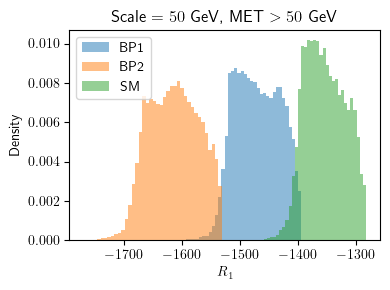

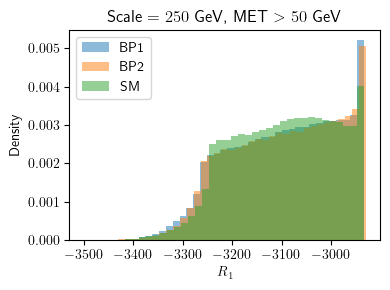

In [28]:

plt.rcParams.update(
{
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{slashed}',
})
# plt.subplot(2, 2, 1)
plt.figure(figsize=(4, 3)) 

# last index is for the scale, second for type and first the PCD
# 1 => Scale=50
plt.hist(R_pcds[6][0][1], bins=40,density=True,  alpha=0.5)
plt.hist(R_pcds[6][1][1], bins=40,density=True,  alpha=0.5)
plt.hist(R_pcds[6][2][1], bins=40,density=True, alpha=0.5)

plt.legend(['BP1','BP2','SM'])

plt.title(r'Scale $=50$ GeV, MET $>50$ GeV')
plt.xlabel(r'$R_1$')
plt.ylabel(r'Density')
plt.tight_layout()

plt.savefig(f'plots/hist_150_R1_Scale_50GeV_MET50.pdf',bbox_inches='tight')


plt.rcParams.update(
{
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{slashed}',
})
# plt.subplot(2, 2, 1)
plt.figure(figsize=(4, 3)) 

plt.hist(R_pcds[6][0][5], bins=40,density=True,  alpha=0.5)
plt.hist(R_pcds[6][1][5], bins=40,density=True,  alpha=0.5)
plt.hist(R_pcds[6][2][5], bins=40,density=True, alpha=0.5)

plt.legend(['BP1','BP2','SM'])

plt.title(r'Scale $=250$ GeV, MET $>50$ GeV')
plt.xlabel(r'$R_1$')
plt.ylabel(r'Density')
plt.tight_layout()

plt.savefig(f'plots/hist_150_R1_Scale_250GeV_MET50.pdf',bbox_inches='tight')


In [16]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, recall_score
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_fscore_support



def get_cl_scores(vector1,vector2,subset_size=None):


    if(subset_size):
        if(len(vector1) >=subset_size and len(vector2) >=subset_size ):
            indices1 = np.random.choice(len(vector1), size=subset_size, replace=False)
            vector1 = np.array(vector1)[indices1].reshape(-1, 1)

            indices2 = np.random.choice(len(vector2), size=subset_size, replace=False)
            vector2 = np.array(vector2)[indices2].reshape(-1, 1)
        
        else:
            vector1 = np.array(vector1).reshape(-1, 1)
            vector2 =np.array(vector2).reshape(-1, 1)

    else:
        vector1 = np.array(vector1).reshape(-1, 1)
        vector2 =np.array(vector2).reshape(-1, 1)
        
    vectors = np.vstack((vector1,  vector2))

    # Step 3: Labeling
    # Assuming we have labels for the vectors (e.g., class 0, class 1, class 2)
    labels = np.concatenate((np.zeros(len(vector1)), 
                             np.ones(len(vector2))))

    X_train0, X_test0, y_train0, y_test0 = train_test_split(vectors, labels , test_size=0.3, random_state=41)

    ## We will train the model using resampling so that the data is not skewed

    smote = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all'))  #SMOTE(random_state=42,k_neighbors=5)
    vectors_res, labels_res = smote.fit_resample(vectors, labels)
    # X_train, X_test, y_train, y_test = train_test_split(vectors_res, labels_res , test_size=0.3, random_state=41)

    # Step 5: Feature Scaling (StandardScaler)
    scaler = StandardScaler()

    X_scaled = scaler.fit_transform(vectors_res)

    # this scaled X will be used for testing against actual data
    X_test0_scaled = scaler.transform(X_test0)

    # Choose a Model (Support Vector Machine)
    model = SVC(kernel='rbf', C=1.0, random_state=42)

    # https://scikit-learn.org/stable/modules/cross_validation.html
    scores = cross_val_score(model,X_scaled,labels_res, cv=10, scoring='accuracy',n_jobs=-1)
    # Print mean accuracy
    # print("Mean Accuracy:", np.mean(scores))

    y_pred = cross_val_predict(model,X_test0_scaled,y_test0, cv=10,n_jobs=-1)
    # Calculate precision, recall, and F1-score
    precision_cv, recall_cv, f1_score_cv, _ = precision_recall_fscore_support(y_test0, y_pred, average='weighted')

    # print("Cross-Validation Precision:", precision_cv)
    # print("Cross-Validation Recall:", recall_cv)
    # print("Cross-Validation F1 Score:", f1_score_cv)

    conf_matrix = confusion_matrix(y_true=y_test0, y_pred=y_pred)
    # Print the confusion matrix
    # print("Confusion Matrix:")
    # print(conf_matrix)
    return [np.mean(scores), precision_cv, recall_cv, f1_score_cv,conf_matrix ]



In [ ]:

def get_acc_pcds(idx):
    
    BP1_res=BP1_pcds[idx]
    BP2_res=BP2_pcds[idx]
    BG1_res=SM_pcds[idx]
    
    R_BP1=R_pcds[idx][0]
    R_BP2=R_pcds[idx][1]
    R_SM=R_pcds[idx][2]

    vector1 = BP1_res[['px','py','pz','E','mt']].to_numpy()
    vector2 = BP2_res[['px','py','pz','E','mt']].to_numpy()
    vector3 = BG1_res[['px','py','pz','E','mt']].to_numpy()

    normal_score_bp1=get_cl_scores(vector1,vector3,20000)
    normal_score_bp2=get_cl_scores(vector2,vector3,20000)

    acc_R_BP1=[]
    scales=[25,50,100,150,200,250,300,350,400,450,500]
    for i in range(len(R_BP1)):
        print(f"BP1, Filtration scale: {scales[i]} \n")

        vector1 = R_BP1[i].to_numpy()
        vector2 = R_SM[i].to_numpy()
        acc_R_BP1.append(get_cl_scores(vector1,vector2,20000))
        
        print("-------------------------------------------\n")


    acc_R_BP2=[]
    for i in range(len(R_BP2)):
        print(f"BP2, Filtration scale: {scales[i]} \n")

        vector1 = R_BP2[i].to_numpy()
        vector2 = R_SM[i].to_numpy()
        acc_R_BP2.append(get_cl_scores(vector1,vector2,20000))
        
        print("-------------------------------------------\n")

    return [normal_score_bp1,normal_score_bp2, acc_R_BP1, acc_R_BP2]
   
    
acc_pcds=[]
for idx in range(n_pcds):
    acc_pcds.append(get_acc_pcds(idx)) 


In [23]:
bp1_acc=[]  
bp2_acc=[] 
acc=[]
scales=[25,50,100,150,200,250,300,350,400,450,500] 
for i in range(n_pcds):
    temp1=[]
    temp2=[]
    
    for j in range(11): # scales
        temp1.append(acc_pcds[i][2][j][0])
        temp2.append(acc_pcds[i][3][j][0])
        temp=[i,scales[j],acc_pcds[i][2][j][0],acc_pcds[i][3][j][0]]
        acc.append(temp)
    bp1_acc.append(temp1)
    bp2_acc.append(temp2)
    
df_acc=pd.DataFrame(acc,columns=['pcd_no','scale','BP1','BP2'] )
df_acc

,pcd_no,scale,BP1,BP2
0,0,25,1.000000,1.000000
1,0,50,0.986634,0.999302
2,0,100,0.765906,0.703725
3,0,150,0.697184,0.620128
4,0,200,0.632314,0.576307
...,...,...,...,...
215,19,300,0.678590,0.675424
216,19,350,0.624625,0.668852
217,19,400,0.562684,0.677989
218,19,450,0.576748,0.648599


In [24]:
df_bp1=pd.DataFrame(bp1_acc,columns=[25,50,100,150,200,250,300,350,400,450,500])
df_bp2=pd.DataFrame(bp2_acc,columns=[25,50,100,150,200,250,300,350,400,450,500])
df_bp1

,25,50,100,150,200,250,300,350,400,450,500
0,1.000000,0.986634,0.765906,0.697184,0.632314,0.590374,0.652492,0.598679,0.604847,0.610169,0.607195
1,0.998998,0.999545,0.673773,0.839632,0.699691,0.677949,0.652732,0.634243,0.566587,0.579922,0.574181
2,1.000000,0.892503,0.952281,0.595744,0.731770,0.692719,0.620786,0.655407,0.575813,0.584702,0.573920
3,1.000000,0.944795,0.962749,0.677723,0.647471,0.670798,0.655802,0.640923,0.639400,0.652677,0.651118
4,0.856344,0.734075,0.973257,0.858992,0.591336,0.665099,0.592691,0.586716,0.569702,0.571704,0.570057
5,1.000000,0.993503,0.819536,0.698465,0.755313,0.602650,0.620598,0.629369,0.613654,0.597307,0.608929
6,1.000000,0.997052,0.828378,0.626311,0.716303,0.619216,0.609017,0.606718,0.606124,0.605610,0.612777
7,1.000000,0.999596,0.866271,0.555593,0.593001,0.575032,0.560855,0.555142,0.578267,0.566975,0.551032
8,1.000000,0.817175,0.928232,0.701380,0.629267,0.602571,0.574115,0.640053,0.629839,0.601868,0.581155
9,1.000000,0.990811,0.907215,0.795894,0.713338,0.666618,0.620989,0.601736,0.598507,0.606994,0.613322


In [25]:
df_bp2

,25,50,100,150,200,250,300,350,400,450,500
0,1.000000,0.999302,0.703725,0.620128,0.576307,0.588693,0.606110,0.582371,0.600558,0.589588,0.586657
1,1.000000,1.000000,0.975267,0.897125,0.635240,0.539404,0.530106,0.534806,0.553298,0.557886,0.550749
2,1.000000,0.998955,0.666814,0.769405,0.651374,0.687312,0.638301,0.637564,0.563874,0.554678,0.556687
3,1.000000,0.994611,0.834952,0.774647,0.735592,0.662219,0.627920,0.636729,0.634118,0.628905,0.632343
4,0.999444,0.880862,0.839511,0.743689,0.626212,0.668909,0.576638,0.553973,0.547596,0.543057,0.540247
5,1.000000,0.999287,0.916924,0.670723,0.669124,0.735580,0.639722,0.649298,0.658709,0.662141,0.660410
6,1.000000,1.000000,0.912101,0.754850,0.693353,0.628185,0.621178,0.624300,0.634217,0.610728,0.614620
7,1.000000,0.999975,0.888048,0.804348,0.626927,0.579934,0.602884,0.585129,0.592568,0.587151,0.609209
8,1.000000,0.976091,0.764835,0.643647,0.631065,0.604719,0.554229,0.632144,0.624726,0.632421,0.585314
9,1.000000,0.999569,0.949944,0.757820,0.722442,0.721043,0.666716,0.608261,0.629260,0.632138,0.646271


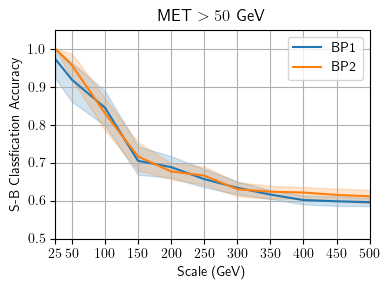

In [26]:
import seaborn as sns

plt.figure(figsize=(4, 3)) 

sns.lineplot(data=df_acc, x="scale", y="BP1",label="BP1")
sns.lineplot(data=df_acc, x="scale", y="BP2",label="BP2")
plt.grid(True)
plt.ylabel('S-B Classfication Accuracy')
plt.xlabel('Scale (GeV)')
plt.xticks(scales)
plt.title(r'MET $>50$ GeV')
plt.ylim([0.5,1.05])
plt.xlim([25,500])
plt.tight_layout()

# Set custom ticks for the x-axis
plt.savefig(f'plots/acc_150_R1.pdf',bbox_inches='tight')


In [27]:
df_acc.to_csv('df_acc_150_pT50_met50',index=False)